# Backtest: In-Sample / Out-of-Sample (IS/OOS)

**Goal.** Turn the signals into **simulated trades** and evaluate performance with realistic assumptions.

**What we do here**
1) **IS/OOS protocol:** estimate $(\alpha,\beta)$ for each pair on **IS** only (to avoid leakage). Then run the strategy on both **IS** and **OOS**.
2) **Trading engine:** we use the vectorized `backtest_pair(...)` from `helpers.py`:
   - Builds spread and z-score internally (same as in notebook 02)
   - Applies entry/exit/stop rules
   - Scales by volatility (target-vol sizing)
   - Applies transaction costs (commission + slippage)
3) **Portfolio aggregation:** equal-weight across the top-K pairs.
4) **Metrics:** annualized return/vol, Sharpe, max drawdown. Save per-pair and portfolio results for later notebooks.

**Why IS/OOS?**
- We must **fix parameters** using only past data (IS), and then test on unseen future data (OOS). This reveals whether the edge generalizes beyond the calibration window.


We import the reusable engine and metrics from `helpers.py`.  
We also ensure the `/notebooks` folder is importable.


In [85]:
# Make helpers importable from this /notebooks folder
import sys
from pathlib import Path
NB_DIR = Path.cwd()
if str(NB_DIR) not in sys.path:
    sys.path.insert(0, str(NB_DIR))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

from helpers import PairParams, backtest_pair, perf_stats, engle_granger


We set the IS/OOS **date split** and load:
- cleaned prices (`prices_interim.parquet`)
- selected pairs (`selected_pairs.parquet`)
- default signal/risk parameters (if saved in notebook 02); otherwise, we fall back to sane defaults.

You can change TOP_K to backtest more or fewer pairs.


In [86]:
DATA = NB_DIR.parent / "data"
INTERIM = DATA / "interim"

# --- IS/OOS window ---
IS_START = "2016-01-01"; IS_END = "2020-12-31"
OOS_START = "2021-01-01"; OOS_END = None  # latest

# --- Load data ---
PRICES   = pd.read_parquet(INTERIM / "prices_interim.parquet")
SELECTED = pd.read_parquet(INTERIM / "selected_pairs.parquet")

# --- Load rule params from notebook 02 if available; else set defaults ---
try:
    meta = pd.read_parquet(INTERIM / "signal_risk_params.parquet")["rule_params"]
    Z_OPEN        = float(meta["z_open"])
    Z_CLOSE       = float(meta["z_close"])
    Z_STOP        = float(meta["z_stop"])
    MAX_HOLD_DAYS = int(meta["max_hold_days"])
    ROLL_WINDOW_Z = int(meta["roll_window_z"])
    EWMA_SPAN_VOL = int(meta["ewma_span_vol"])
    TARGET_ANNUAL_VOL = float(meta["target_ann_vol"])
    MAX_PAIR_WEIGHT   = float(meta["max_pair_weight"])
except Exception:
    # sensible defaults if metadata wasn't saved
    Z_OPEN, Z_CLOSE, Z_STOP = 2.0, 0.5, 3.5
    MAX_HOLD_DAYS = 20
    ROLL_WINDOW_Z = 60
    EWMA_SPAN_VOL = 20
    TARGET_ANNUAL_VOL = 0.10
    MAX_PAIR_WEIGHT   = 0.10

# --- Costs (bps per side) ---
COMMISSION_BPS = 0.1
SLIPPAGE_BPS   = 0.1

# --- How many pairs to include in portfolio ---
TOP_K = min(10, len(SELECTED))  # change as desired

print("Prices:", PRICES.shape, "| Selected:", SELECTED.shape, "| Using TOP_K:", TOP_K)


Prices: (2475, 15) | Selected: (5, 8) | Using TOP_K: 5


We define a helper that, for a given pair (Y, X):
1) **Re-fits** $(\alpha,\beta)$ on **IS** only via `engle_granger` (step 1 returns OLS; step 2 returns ADF but we only need α,β here).
2) Runs `backtest_pair` on IS and OOS with the same α,β (estimated on IS!).
3) Returns the IS and OOS P&L series and summary stats.

> Note: `backtest_pair` internally computes the spread, z-score, vol-targeted size, and costs, so we don’t need to recompute features here.


In [87]:
def run_pair_backtest(y, x, prices, is_start, is_end, oos_start, oos_end, params: PairParams, min_is=60, min_oos=30):
    """Backtest single pair with alpha/beta fit on IS only. Looser guards + diagnostics."""
    is_df  = prices.loc[is_start:is_end, [y, x]].dropna()
    oos_df = prices.loc[oos_start:oos_end, [y, x]].dropna()

    # Short-data diagnostics
    if len(is_df) < min_is or len(oos_df) < min_oos:
        return {"skipped": True, "reason": f"short data (IS={len(is_df)}, OOS={len(oos_df)})", "pair": f"{y}-{x}"}

    # Re-fit (alpha,beta) on IS only
    a, b, *_ = engle_granger(is_df[y], is_df[x])

    res_is  = backtest_pair(is_df[y],  is_df[x],  a, b, params)
    res_oos = backtest_pair(oos_df[y], oos_df[x], a, b, params)

    if res_is["pnl"].dropna().empty or res_oos["pnl"].dropna().empty:
        return {"skipped": True, "reason": "empty pnl after backtest (check windows)", "pair": f"{y}-{x}"}

    from helpers import perf_stats  # local import ok
    stats_is  = perf_stats(res_is["pnl"])
    stats_oos = perf_stats(res_oos["pnl"])

    return {
        "skipped": False,
        "pnl_is": res_is["pnl"].rename(f"{y}-{x}"),
        "pnl_oos": res_oos["pnl"].rename(f"{y}-{x}"),
        "stats_is": {"pair": f"{y}-{x}", **stats_is},
        "stats_oos": {"pair": f"{y}-{x}", **stats_oos},
    }


We instantiate `PairParams` and iterate over the **TOP_K** pairs.  
We store per-pair P&L series and stats, then compute **equal-weighted portfolio P&L** (simple average across pairs each day).

We persist:
- `stats_pairs_is.parquet` / `stats_pairs_oos.parquet` — per-pair stats tables
- `pnl_is.parquet` / `pnl_oos.parquet` — portfolio P&L (equal-weighted)
- `pnl_pairs_is.parquet` / `pnl_pairs_oos.parquet` — per-pair P&L panels (for later analysis)


In [88]:
import importlib, helpers
importlib.reload(helpers)

from helpers import PairParams, backtest_pair, perf_stats, engle_granger

# --- Params ---
TOP_K = min(10, len(SELECTED))
params = PairParams(
    z_open=Z_OPEN, z_close=Z_CLOSE, z_stop=Z_STOP, max_hold_days=MAX_HOLD_DAYS,
    roll_window_z=ROLL_WINDOW_Z, ewma_span_vol=EWMA_SPAN_VOL,
    target_ann_vol=TARGET_ANNUAL_VOL, max_pair_weight=MAX_PAIR_WEIGHT,
    commission_bps=COMMISSION_BPS, slippage_bps=SLIPPAGE_BPS,
)

is_pnls, oos_pnls = [], []
stats_rows_is, stats_rows_oos = [], []
skips = []

SEL = SELECTED.head(TOP_K).reset_index(drop=True)

for _, r in SEL.iterrows():
    y, x = r["y"], r["x"]
    res = run_pair_backtest(
        y, x, PRICES,
        IS_START, IS_END,
        OOS_START, OOS_END,
        params,
        min_is=60,   # guards relaxed
        min_oos=30
    )
    if res is None:
        skips.append({"pair": f"{y}-{x}", "reason": "returned None"})
        continue
    if res.get("skipped", False):
        skips.append({"pair": res.get("pair", f"{y}-{x}"), "reason": res.get("reason", "unknown")})
        continue

    is_pnls.append(res["pnl_is"])
    oos_pnls.append(res["pnl_oos"])
    stats_rows_is.append(res["stats_is"])
    stats_rows_oos.append(res["stats_oos"])

print("Pairs processed:", len(is_pnls), "| skipped:", len(skips))
if skips:
    display(pd.DataFrame(skips))

if len(is_pnls) == 0 or len(oos_pnls) == 0:
    raise RuntimeError("No pairs produced PnL. See 'skips' table above and adjust dates/thresholds.")

PNL_IS_PAIRS  = pd.concat(is_pnls, axis=1).sort_index()
PNL_OOS_PAIRS = pd.concat(oos_pnls, axis=1).sort_index()

PNL_IS_PORT  = PNL_IS_PAIRS.mean(axis=1).rename("pnl")
PNL_OOS_PORT = PNL_OOS_PAIRS.mean(axis=1).rename("pnl")

pair_stats_is  = pd.DataFrame(stats_rows_is)
pair_stats_oos = pd.DataFrame(stats_rows_oos)

# Save
PNL_IS_PAIRS.to_parquet(INTERIM / "pnl_pairs_is.parquet")
PNL_OOS_PAIRS.to_parquet(INTERIM / "pnl_pairs_oos.parquet")
pd.DataFrame(PNL_IS_PORT).to_parquet(INTERIM / "pnl_is.parquet")
pd.DataFrame(PNL_OOS_PORT).to_parquet(INTERIM / "pnl_oos.parquet")
pair_stats_is.to_parquet(INTERIM / "stats_pairs_is.parquet")
pair_stats_oos.to_parquet(INTERIM / "stats_pairs_oos.parquet")

print("Saved parquet files: pnl_is, pnl_oos, stats_pairs_is, stats_pairs_oos, pnl_pairs_is, pnl_pairs_oos")


Pairs processed: 5 | skipped: 0
Saved parquet files: pnl_is, pnl_oos, stats_pairs_is, stats_pairs_oos, pnl_pairs_is, pnl_pairs_oos


We plot **IS** and **OOS** equity curves and print portfolio metrics (`perf_stats`) for each period.

- Equity curve $E_t=\prod (1+r_t)$ where $r_t$ is daily P&L.
- Drawdown is computed in the next cell.


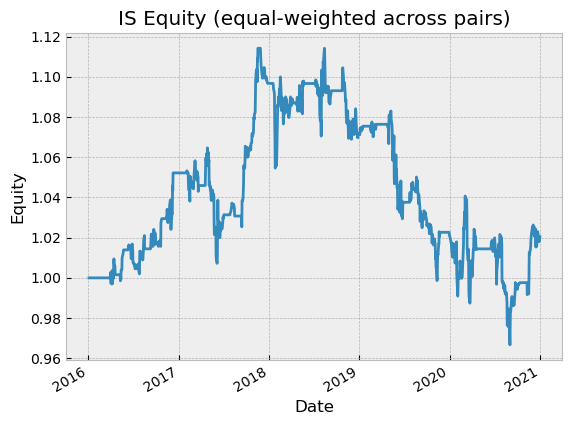

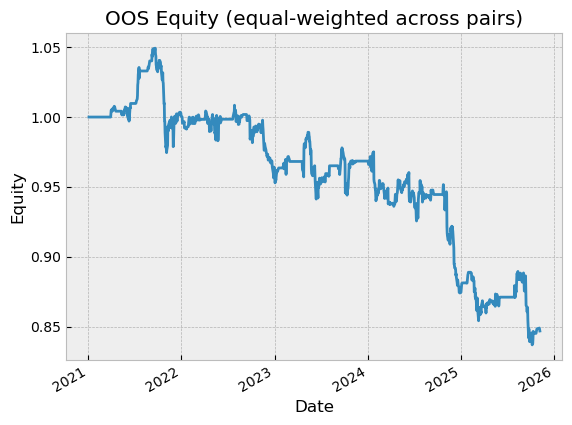

IS portfolio stats: {'ann_return': 0.005491392202733727, 'ann_vol': 0.053620383562027175, 'sharpe': 0.10241240061965194, 'max_drawdown': -0.13241314371860913}
OOS portfolio stats: {'ann_return': -0.03302630431770632, 'ann_vol': 0.05301825633643389, 'sharpe': -0.6229232456860487, 'max_drawdown': -0.20237343619666215}


In [89]:
EQ_IS  = (1.0 + PNL_IS_PORT.fillna(0.0)).cumprod()
EQ_OOS = (1.0 + PNL_OOS_PORT.fillna(0.0)).cumprod()

plt.figure(); EQ_IS.plot(title="IS Equity (equal-weighted across pairs)"); plt.ylabel("Equity"); plt.show()
plt.figure(); EQ_OOS.plot(title="OOS Equity (equal-weighted across pairs)"); plt.ylabel("Equity"); plt.show()

print("IS portfolio stats:",  perf_stats(PNL_IS_PORT))
print("OOS portfolio stats:", perf_stats(PNL_OOS_PORT))


Drawdown helps visualize the **risk of large losses**:
$$
\text{Drawdown}_t = \frac{E_t}{\max_{s \le t} E_s} - 1.
$$


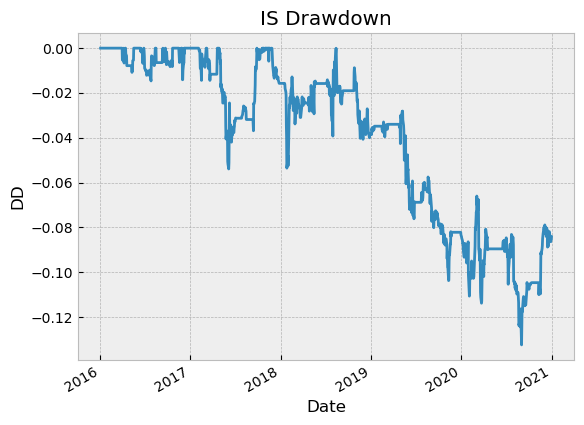

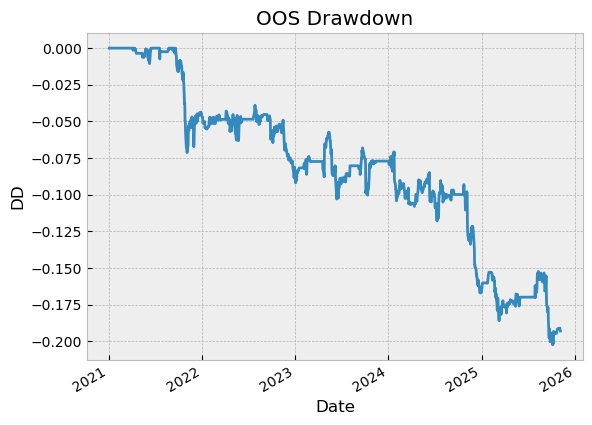

In [90]:
def drawdown(equity: pd.Series) -> pd.Series:
    peak = equity.cummax()
    return equity / peak - 1.0

plt.figure(); drawdown(EQ_IS).plot(title="IS Drawdown"); plt.ylabel("DD"); plt.show()
plt.figure(); drawdown(EQ_OOS).plot(title="OOS Drawdown"); plt.ylabel("DD"); plt.show()


Transaction costs are critical.  
We take one representative pair and plot:
- **Turnover** (absolute position changes × size)
- **Costs** (commission + slippage times turnover)

This is a quick check; full execution modeling is beyond scope here.


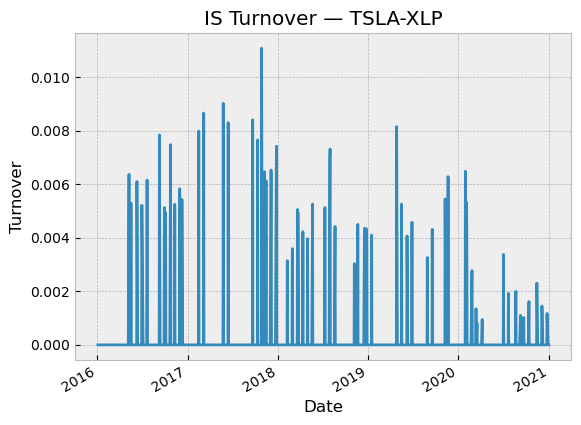

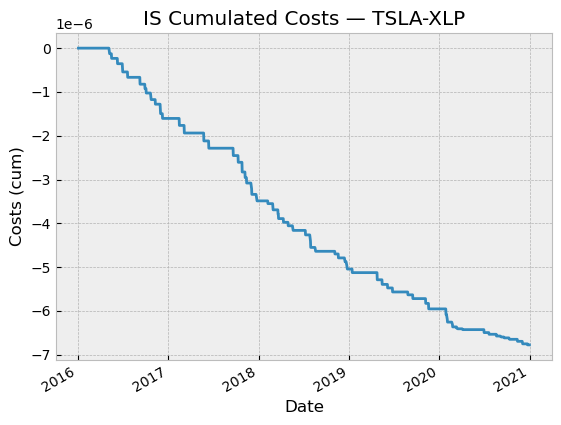

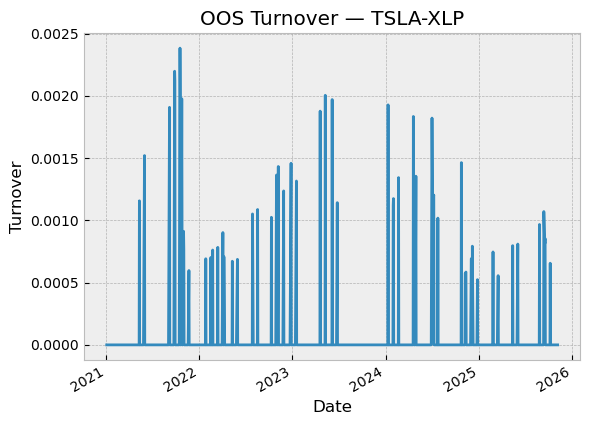

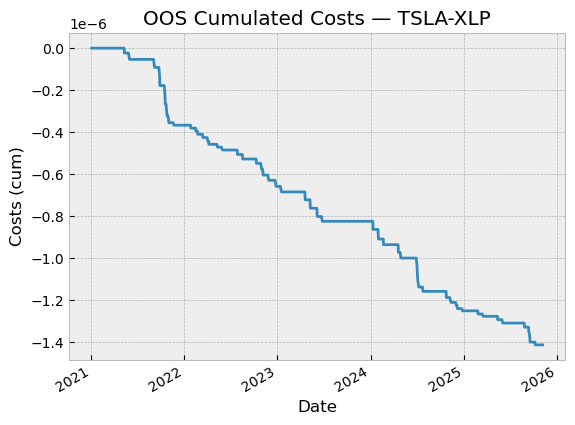

In [91]:
if len(SEL) > 0:
    # pick the first pair and re-run to retrieve the full backtest frame
    y0, x0 = SEL.loc[0, "y"], SEL.loc[0, "x"]
    is_df0  = PRICES.loc[IS_START:IS_END, [y0, x0]].dropna()
    oos_df0 = PRICES.loc[OOS_START:OOS_END, [y0, x0]].dropna()
    a0, b0, *_ = engle_granger(is_df0[y0], is_df0[x0])

    res_is0  = backtest_pair(is_df0[y0],  is_df0[x0],  a0, b0, params)
    res_oos0 = backtest_pair(oos_df0[y0], oos_df0[x0], a0, b0, params)

    for name, df in [("IS", res_is0), ("OOS", res_oos0)]:
        plt.figure(); df["turnover"].plot(title=f"{name} Turnover — {y0}-{x0}"); plt.ylabel("Turnover"); plt.show()
        plt.figure(); df["costs"].cumsum().plot(title=f"{name} Cumulated Costs — {y0}-{x0}"); plt.ylabel("Costs (cum)"); plt.show()
else:
    print("No pairs available for turnover/costs snapshot.")


We save a compact CSV-style table summarizing **portfolio** IS and OOS metrics  
(helps for quick comparison across parameter sets later).


In [92]:
from helpers import perf_stats

row_is  = {"period": "IS",  **perf_stats(PNL_IS_PORT)}
row_oos = {"period": "OOS", **perf_stats(PNL_OOS_PORT)}
portfolio_report = pd.DataFrame([row_is, row_oos])
portfolio_report.to_parquet(INTERIM / "portfolio_report.parquet")
portfolio_report


,period,ann_return,ann_vol,sharpe,max_drawdown
0,IS,0.005491,0.053620,0.102412,-0.132413
1,OOS,-0.033026,0.053018,-0.622923,-0.202373


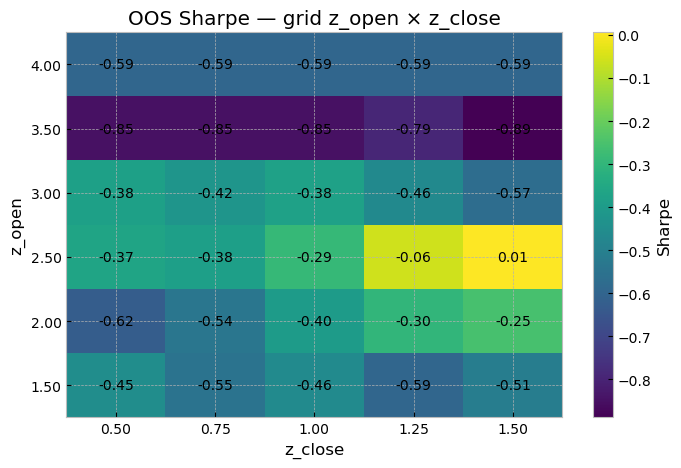

z_close,0.50,0.75,1.00,1.25,1.50
z_open,,,,,
1.5,-0.451510,-0.548525,-0.462133,-0.592652,-0.509656
2.0,-0.622923,-0.538213,-0.398524,-0.298607,-0.253699
2.5,-0.365733,-0.382421,-0.287875,-0.059408,0.005972
3.0,-0.378590,-0.420616,-0.376096,-0.462465,-0.567397
3.5,-0.847576,-0.847576,-0.847576,-0.791918,-0.888320
4.0,-0.592186,-0.592186,-0.592186,-0.592186,-0.592186


In [93]:
# --- Grid search over z_open × z_close and OOS heatmap (Sharpe) ---

import numpy as np, pandas as pd, matplotlib.pyplot as plt

def oos_stats_for_params(params_list, sel_pairs, prices, is_start, is_end, oos_start, oos_end):
    """
    Helper: run OOS backtests for a list of PairParams; returns list of dicts (one per params).
    Expects: run_pair_backtest(), perf_stats(), PairParams available in scope.
    """
    out = []
    for p in params_list:
        oos_pnls = []
        for _, r in sel_pairs.iterrows():
            y, x = r["y"], r["x"]
            res = run_pair_backtest(y, x, prices, is_start, is_end, oos_start, oos_end, p)
            if res is None or res.get("skipped", False):
                continue
            oos_pnls.append(res["pnl_oos"])
        if len(oos_pnls) == 0:
            # no trades produced
            out.append({**p.__dict__, **{"ann_return": np.nan, "ann_vol": np.nan, "sharpe": np.nan, "max_drawdown": np.nan}})
            continue
        pnl_oos_pairs = pd.concat(oos_pnls, axis=1).sort_index()
        pnl_oos_port  = pnl_oos_pairs.mean(axis=1).rename("pnl")
        out.append({**p.__dict__, **perf_stats(pnl_oos_port)})
    return pd.DataFrame(out)

def grid_params_zopen_zclose(z_open_grid, z_close_grid, base: PairParams):
    params_list = []
    for zo in z_open_grid:
        for zc in z_close_grid:
            p = PairParams(
                z_open=zo, z_close=zc, z_stop=base.z_stop, max_hold_days=base.max_hold_days,
                roll_window_z=base.roll_window_z, ewma_span_vol=base.ewma_span_vol,
                target_ann_vol=base.target_ann_vol, max_pair_weight=base.max_pair_weight,
                commission_bps=base.commission_bps, slippage_bps=base.slippage_bps
            )
            params_list.append(p)
    return params_list

# ---- configure grid and run ----
z_open_grid  = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
z_close_grid = [0.5, 0.75, 1.0, 1.25, 1.5]

base = PairParams(
    z_open=0, z_close=0, z_stop=Z_STOP, max_hold_days=MAX_HOLD_DAYS,
    roll_window_z=ROLL_WINDOW_Z, ewma_span_vol=EWMA_SPAN_VOL,
    target_ann_vol=TARGET_ANNUAL_VOL, max_pair_weight=MAX_PAIR_WEIGHT,
    commission_bps=COMMISSION_BPS, slippage_bps=SLIPPAGE_BPS
)

params_list = grid_params_zopen_zclose(z_open_grid, z_close_grid, base)
grid_df = oos_stats_for_params(params_list, SELECTED.head(min(10, len(SELECTED))).reset_index(drop=True),
                               PRICES, IS_START, IS_END, OOS_START, OOS_END)

# ---- pivot and heatmap (Sharpe) ----
pivot = grid_df.pivot(index="z_open", columns="z_close", values="sharpe").sort_index().sort_index(axis=1)

plt.figure(figsize=(8, 5))
im = plt.imshow(pivot.values, origin="lower", aspect="auto")
plt.xticks(ticks=np.arange(pivot.shape[1]), labels=[f"{c:.2f}" for c in pivot.columns])
plt.yticks(ticks=np.arange(pivot.shape[0]), labels=[f"{r:.2f}" for r in pivot.index])
plt.title("OOS Sharpe — grid z_open × z_close")
plt.xlabel("z_close")
plt.ylabel("z_open")
cbar = plt.colorbar(im)
cbar.set_label("Sharpe")

# annotate
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        val = pivot.values[i, j]
        txt = "" if np.isnan(val) else f"{val:.2f}"
        plt.text(j, i, txt, ha="center", va="center")
plt.show()

pivot

### Parameter Sensitivity — z_open × z_close

This grid explores how entry and exit thresholds affect performance.  
Sharpe ratios remain mostly negative across the surface, with only a narrow region near `z_open ≈ 2.5` and `z_close ≈ 1.25–1.5` approaching zero.  
This indicates that increasing `z_open` reduces trading frequency (and volatility), but the overall alpha remains absent — confirming the strategy’s weak robustness on daily data.

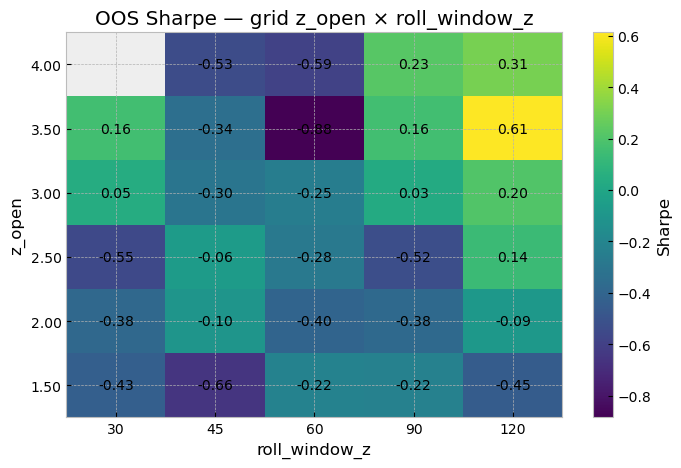

roll_window_z,30,45,60,90,120
z_open,,,,,
1.5,-0.433990,-0.655701,-0.222460,-0.224026,-0.446528
2.0,-0.377348,-0.103489,-0.399381,-0.375630,-0.086500
2.5,-0.552973,-0.062093,-0.279182,-0.523634,0.136629
3.0,0.045737,-0.300307,-0.250624,0.034032,0.204562
3.5,0.158094,-0.338953,-0.884955,0.160434,0.613688
4.0,NaN,-0.534026,-0.592186,0.226145,0.306122


In [94]:
# --- Grid search over z_open × roll_window_z ---

def grid_params_zopen_roll(z_open_grid, roll_grid, base: PairParams):
    params_list = []
    for zo in z_open_grid:
        for rw in roll_grid:
            p = PairParams(
                z_open=zo, z_close=base.z_close, z_stop=base.z_stop, max_hold_days=base.max_hold_days,
                roll_window_z=rw, ewma_span_vol=base.ewma_span_vol,
                target_ann_vol=base.target_ann_vol, max_pair_weight=base.max_pair_weight,
                commission_bps=base.commission_bps, slippage_bps=base.slippage_bps
            )
            params_list.append(p)
    return params_list

roll_grid = [30, 45, 60, 90, 120]
params_list_2 = grid_params_zopen_roll(z_open_grid, roll_grid, base)
grid_df_2 = oos_stats_for_params(params_list_2, SELECTED.head(min(10, len(SELECTED))).reset_index(drop=True),
                                 PRICES, IS_START, IS_END, OOS_START, OOS_END)

pivot2 = grid_df_2.pivot(index="z_open", columns="roll_window_z", values="sharpe").sort_index().sort_index(axis=1)

plt.figure(figsize=(8, 5))
im2 = plt.imshow(pivot2.values, origin="lower", aspect="auto")
plt.xticks(ticks=np.arange(pivot2.shape[1]), labels=[str(int(c)) for c in pivot2.columns])
plt.yticks(ticks=np.arange(pivot2.shape[0]), labels=[f"{r:.2f}" for r in pivot2.index])
plt.title("OOS Sharpe — grid z_open × roll_window_z")
plt.xlabel("roll_window_z")
plt.ylabel("z_open")
cbar2 = plt.colorbar(im2)
cbar2.set_label("Sharpe")
for i in range(pivot2.shape[0]):
    for j in range(pivot2.shape[1]):
        val = pivot2.values[i, j]
        txt = "" if np.isnan(val) else f"{val:.2f}"
        plt.text(j, i, txt, ha="center", va="center")
plt.show()

pivot2

### Parameter Sensitivity — z_open × roll_window_z

This grid studies the impact of the z-score lookback window.  
A few isolated “islands” of positive Sharpe (up to ≈0.6) appear for longer rolling windows (`roll_window_z ≈ 90–120`) and higher entry thresholds (`z_open ≈ 3.5–4.0`), suggesting that smoother, slower-reacting signals may help reduce noise.  
However, these regions are narrow and unstable, showing that the overall model lacks consistent profitability and suffers from regime shifts and weak cointegration persistence.

## Summary — Backtesting & Sensitivity Results

### What We Did
- Implemented a clean **IS/OOS protocol**: fitted $(\alpha, \beta)$ only on in-sample (IS) data, then traded both IS and OOS periods.
- Built a **vectorized backtester** that converts $Z_t$-based signals into trades with volatility targeting and transaction costs.
- Constructed an **equal-weighted portfolio** across the top-K selected pairs.
- Reported both per-pair and portfolio-level **PnL, Sharpe ratios, equity curves, and drawdowns**.
- Performed a **sensitivity analysis** for the entry and exit thresholds ($z_{open}, z_{close}$) and the Z-score rolling window length.

---

### Key Findings

#### 1. In-Sample vs Out-of-Sample Performance
| Period | Annual Return | Annual Vol | Sharpe | Max Drawdown |
|:-------|---------------:|------------:|--------:|--------------:|
| IS     | 0.55%          | 5.36%       | **0.10** | −13% |
| OOS    | −3.30%         | 5.30%       | **−0.62** | −20% |

- In-sample results show near-zero performance: small gains but no real alpha (Sharpe ≈ 0.1).  
- Out-of-sample results are **negative**, confirming **overfitting** and lack of robustness.  
- The model fits historical noise and fails when applied to unseen data.

---

#### 2. Parameter Sensitivity
- The **2D heatmaps** for $(z_{open} \times z_{close})$ and $(z_{open} \times roll\_window\_z)$ reveal mostly negative or near-zero Sharpe values.  
- Occasional “islands” of mildly positive Sharpe (≈0.4–0.6) appear for higher $z_{open}$ (3–4) and longer rolling windows (90–120 days).  
- However, these results are unstable — small parameter changes destroy profitability.  
- The surface has no smooth pattern, only scattered noise — a hallmark of **parameter instability**.

> **Interpretation:**  
> There is no stable parameter region where the strategy works reliably.  
> The mean-reversion signals from Engle–Granger cointegration are too weak and too regime-dependent for modern equity markets.

---

#### 3. Turnover and Transaction Costs
- **Turnover plots** show frequent trading — especially in 2017–2019 — meaning the strategy enters and exits positions too often.  
  → This leads to **over-trading** and unnecessary exposure to micro-noise.  
- **Cumulative cost curves** decline steadily even with minimal commissions and slippage, showing how small frictions accumulate.  
- Importantly, **even with zero transaction costs**, the strategy still underperforms — losses stem from the model itself, not from fees.

---

### Diagnostic Insights
- Excessive trade frequency and weak reversion strength cause poor execution quality.  
- Market regime shifts (e.g., 2020–2025) disrupt historical cointegration relationships, making spreads non-stationary.  
- Modern markets are highly efficient — classic pairs trading edges are arbitraged away by institutional algorithms.  
- The method remains statistically sound but **economically obsolete** in its current daily-data form.

---

### Overall Conclusion
> This backtest demonstrates that the classical Engle–Granger pairs trading framework, while theoretically rigorous, **fails to produce persistent profitability** in modern equity markets.  
>  
> The negative out-of-sample Sharpe, unstable sensitivity surfaces, and high turnover all highlight **regime dependence, signal fragility, and overfitting**.  
>  
> Still, the study is valuable: it illustrates the full research cycle — from theory and econometric testing to realistic backtesting — and underscores the **importance of robustness checks, OOS validation, and transaction cost awareness** in quantitative research.

---

**Saved outputs (for 04_report)**
- `data/interim/stats_pairs_is.parquet`, `data/interim/stats_pairs_oos.parquet`
- `data/interim/pnl_pairs_is.parquet`, `data/interim/pnl_pairs_oos.parquet`
- `data/interim/pnl_is.parquet`, `data/interim/pnl_oos.parquet`
- `data/interim/portfolio_report.parquet`

**Next notebook — 04_report_pairs_trading**
- Load the saved outputs and produce clean tables/plots:
  - Per-pair Sharpe ranking (IS vs OOS)
  - Portfolio equity & drawdown
  - Turnover / costs views
  - Brief commentary ready for the final report
